Let's take a closer look at the new phenotype files. **NOTE** the clean set for all WES analysis only removes the well-know variants, not the other stuff PennCNV recommends!:

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [114]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [115]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in (y_cols + ['ncnv'])]
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + ['ncnv']))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))

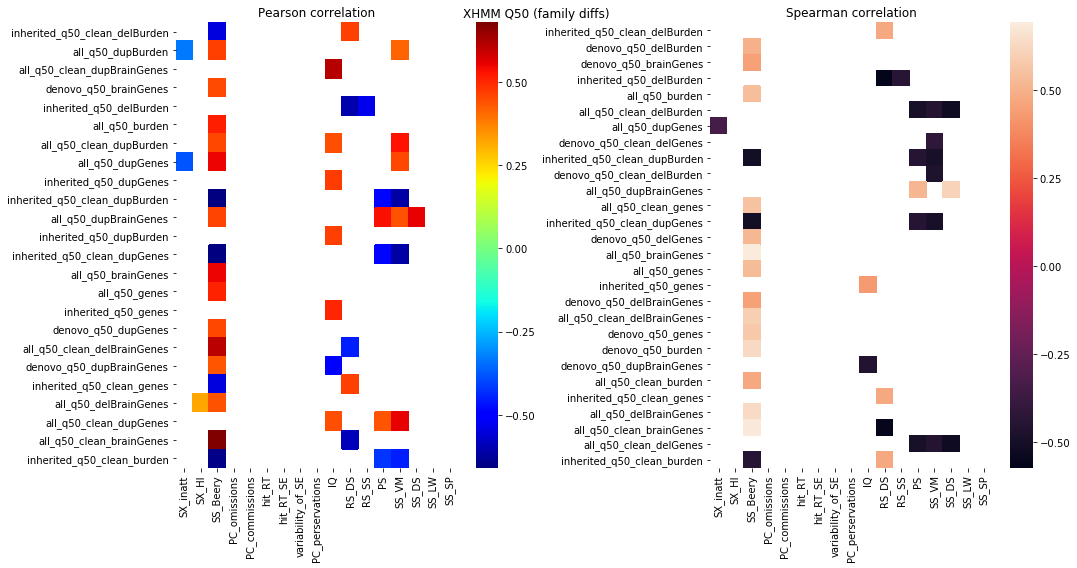

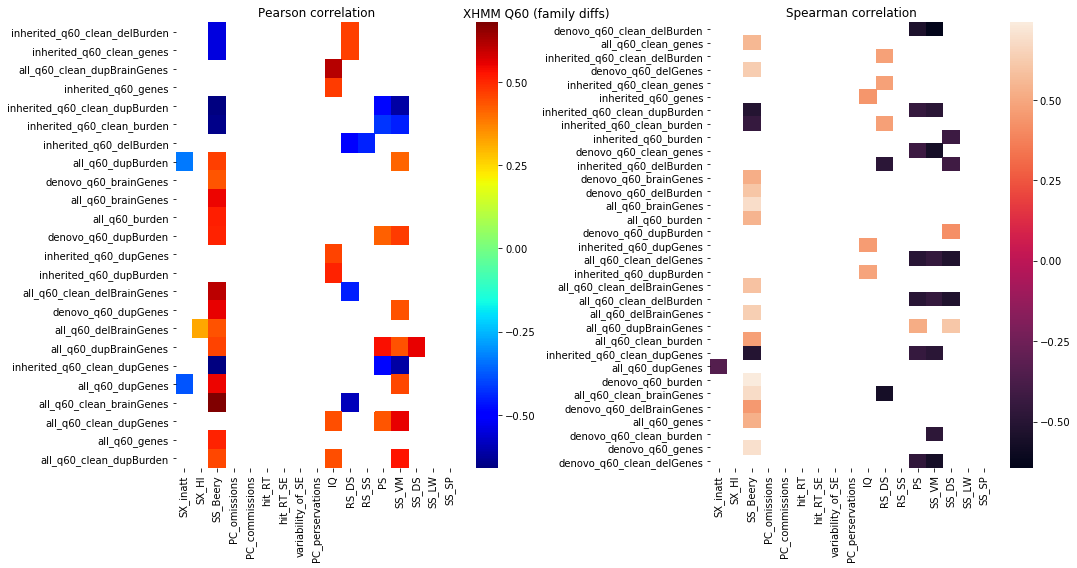

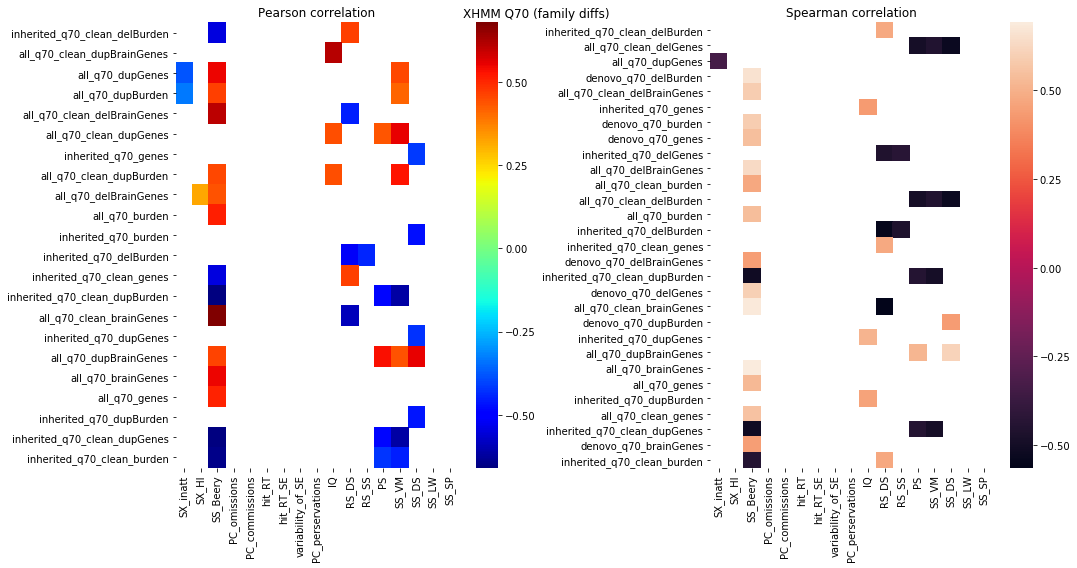

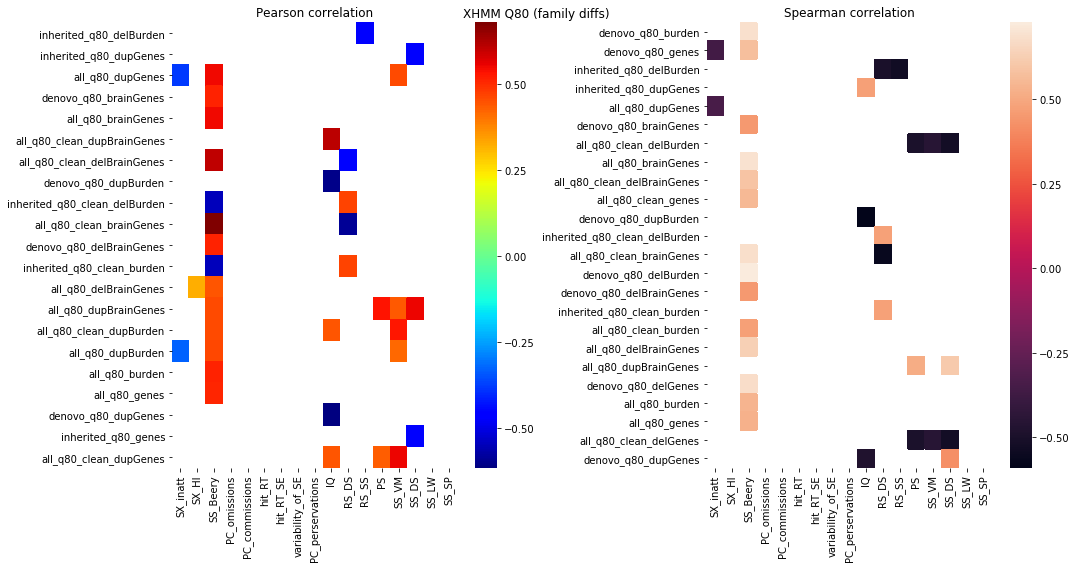

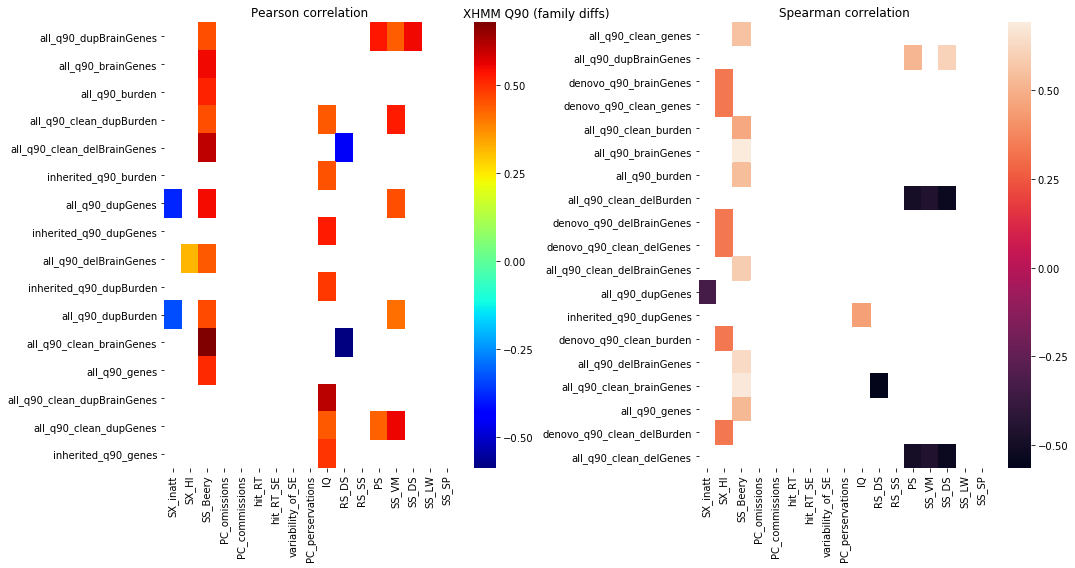

In [6]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

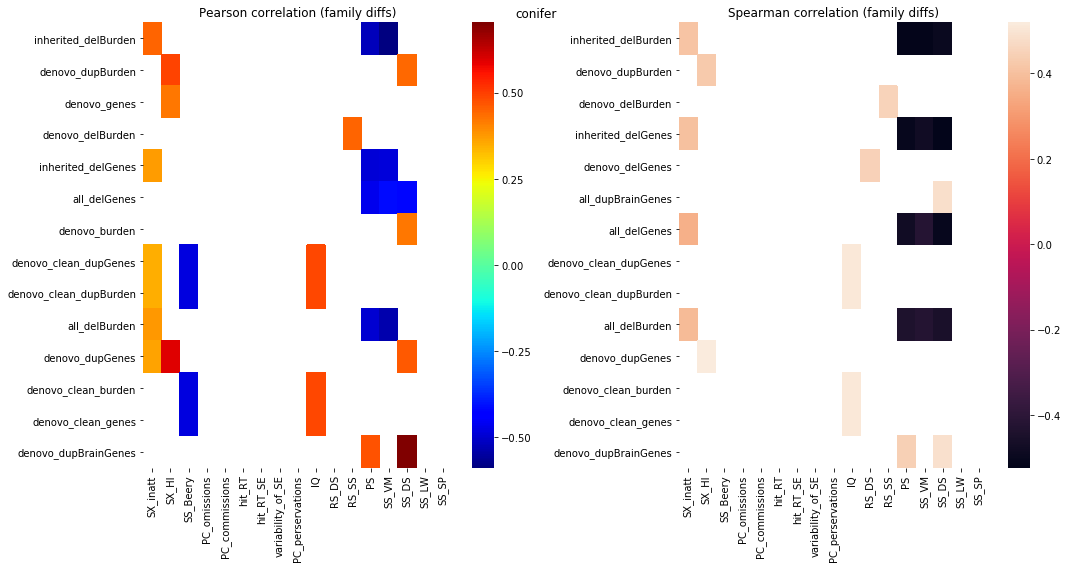

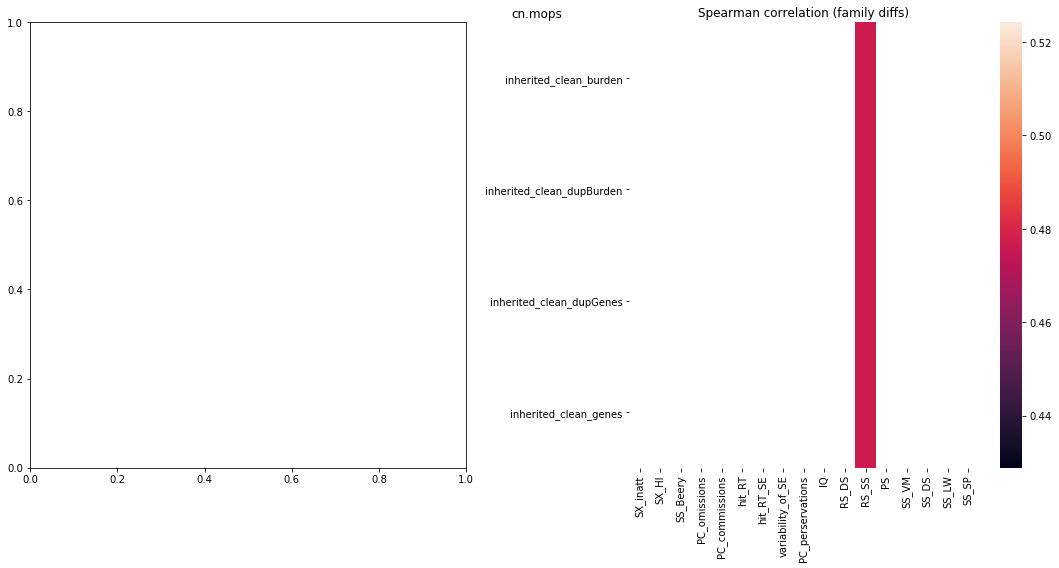

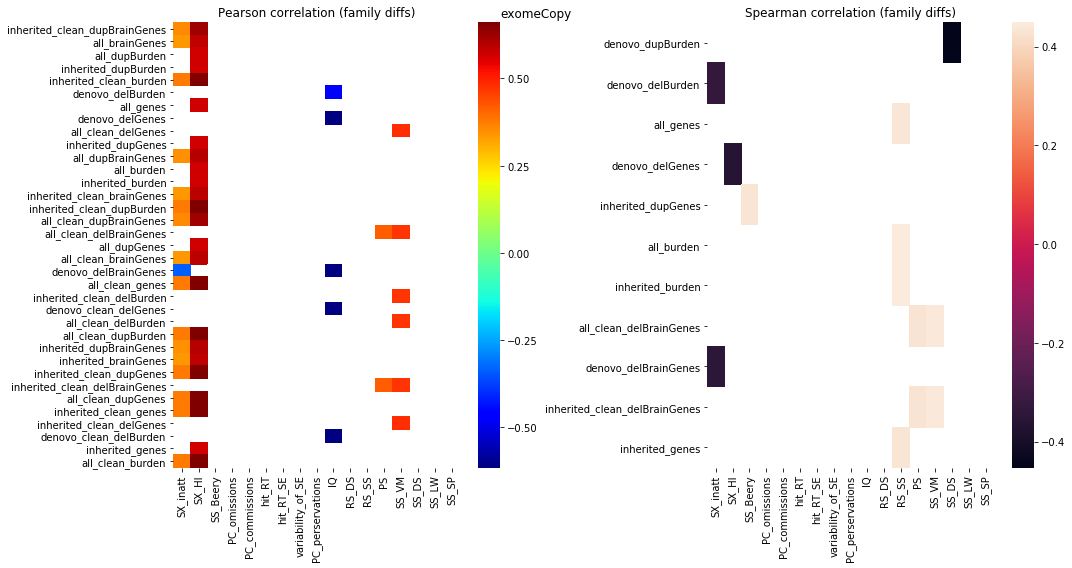

In [116]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for tool in ['conifer', 'cn.mops', 'exomeCopy']:
    data_dir = '/home/sudregp/data/cnv/%s_multikids/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation (family diffs)')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation (family diffs)')
    plt.suptitle('%s' % tool)
    plt.tight_layout()
    plt.show()

There are a few interesting results to explore further:
 * all_dupGenes results, across the board on XHMM
 * Beery results, across the board on XHMM
 
and a few others... let's see how the data looks.

In [13]:
from itertools import combinations
from scipy import stats


# returns X and Y for a correlation plot
def get_xy(fname, ycol, diff=False, x='ncnv'):
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    
    if diff:
        # the idea is to create a new data frame that only has the differences
        # among the phenotypes
    
        # loop through families
        rows = []
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            # get all combinations of kids
            if len(fam_kids) > 1:
                for kid1, kid2 in combinations(fam_kids, 2):
                    if kid1 in good_kids and kid2 in good_kids:
                        row1 = data[data['code'] == kid1]
                        row2 = data[data['code'] == kid2]
                        new_row = [np.float(row1[y]) - np.float(row2[y])
                                   for y in [ycol, 'ncnv']]
                    rows.append(new_row)
        data = pd.DataFrame(rows, columns=[ycol, 'ncnv'])

    tmp_df = data[[x, ycol]].dropna()
    return tmp_df

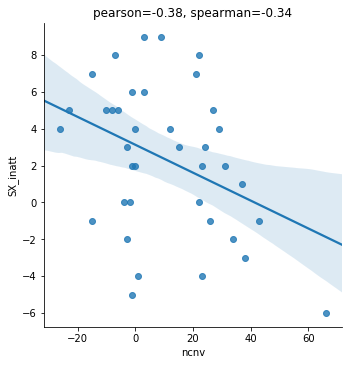

In [26]:
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')
df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/all_q50_dupGenes.cnv.indiv',
       'SX_inatt', diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y='SX_inatt', data=res)
plt.title(t_str)

There's something interesting there. Even better that it survives multiple Q thresholds.

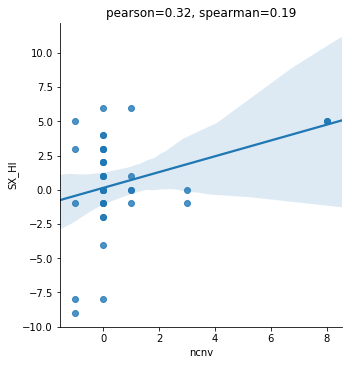

In [27]:
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/all_q50_delBrainGenes.cnv.indiv',
       'SX_HI', diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y='SX_HI', data=res)
plt.title(t_str)

Looks like it's being driven by the outlier... also, even though it's there for many Q thresholds, it only works for Pearson correlation. Maybe use it later, but there's strong stuff out there.

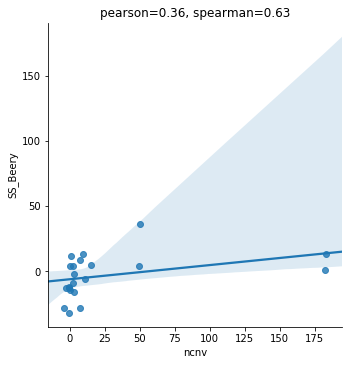

In [28]:
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/denovo_q50_burden.cnv.indiv',
       'SS_Beery', diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y='SS_Beery', data=res)
plt.title(t_str)

There are some big outliers here. Let's check other thresholds"

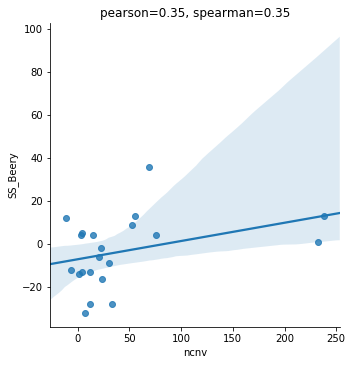

In [31]:
y='SS_Beery'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/all_q80_delGenes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

So, it's the 2 outliers again. Who are they?

In [33]:
%%bash
cat /home/sudregp/data/cnv/xhmm_multikids/all_q80_delGenes.cnv.indiv

 FID           IID  PHE     NSEG       KB    KBAVG 
   1   CLIA_400216    2       28  1037.24  37.0441 
   1   CLIA_400133    1       57  3623.59  63.5718 
   1   CLIA_400176    1        0        0        0
   1   CLIA_400177    1        0        0        0
   1   CLIA_400134    2       58  3413.16  58.8477 
   1   CLIA_400175    1       43  2665.99  61.9997 
   1   CLIA_400174    1        0        0        0
   1   CLIA_400173    1        0        0        0
   1   CLIA_400163    2       61  2306.99  37.8195 
   1   CLIA_400162    1       72  2963.39  41.1582 
   1   CLIA_400161    1        0        0        0
   1   CLIA_400160    1        0        0        0
   1   CLIA_400132    2       52   3445.8  66.2654 
   1   CLIA_400158    1       40  2208.97  55.2242 
   1   CLIA_400156    1        0        0        0
   1   CLIA_400157    1        0        0        0
   1   CLIA_400203    1      114  2356.09  20.6674 
   1   CLIA_400204    2       45  1387.12  30.8248 
   1   CLIA_400201  

Of course: 400178. And it is related to two other kids: 

In [34]:
print [t['famid'] for t in trios if t['child']=='CLIA_400178']

['10406']


In [35]:
[t['child'] for t in trios if t['famid']=='10406']

['CLIA_400178', 'CLIA_400179', 'CLIA_400180']

So, it could be that this child is really that disrupted when we count in deletions. We should look into it a bit more.

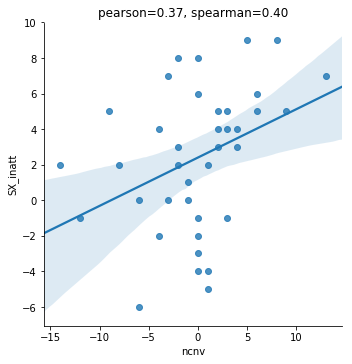

In [36]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/conifer_multikids/inherited_delGenes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

Another point for inattention... now from a different tool. Let's re-code that function so that we fix the phenotype difference to always be positive, so that there is more meaning to these plots:

In [124]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = []
                            for y in (y_cols + [x]):
                                if np.float(row1[x]) > np.float(row2[x]):
                                    new_row.append(np.float(row1[y]) - 
                                                   np.float(row2[y]))
                                else:
                                    new_row.append(np.float(row2[y]) - 
                                                   np.float(row1[y]))
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + [x]))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))


# returns X and Y for a correlation plot
def get_xy(fname, ycol, diff=False, x='ncnv'):
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    
    if diff:
        # the idea is to create a new data frame that only has the differences
        # among the phenotypes
    
        # loop through families
        rows = []
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            # get all combinations of kids
            if len(fam_kids) > 1:
                for kid1, kid2 in combinations(fam_kids, 2):
                    if kid1 in good_kids and kid2 in good_kids:
                        row1 = data[data['code'] == kid1]
                        row2 = data[data['code'] == kid2]
                        if np.float(row1[x]) > np.float(row2[x]):
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in [ycol, x]]
                        else:
                            new_row = [np.float(row2[y]) - np.float(row1[y])
                                       for y in [ycol, x]]
                    rows.append(new_row)
        data = pd.DataFrame(rows, columns=[ycol, x])

    tmp_df = data[[x, ycol]].dropna()
    return tmp_df

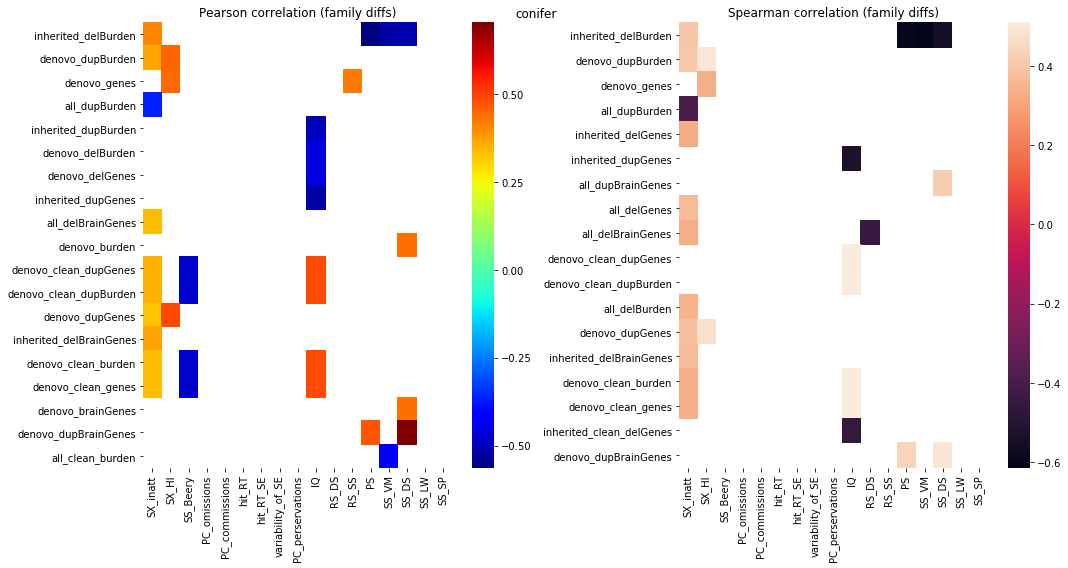

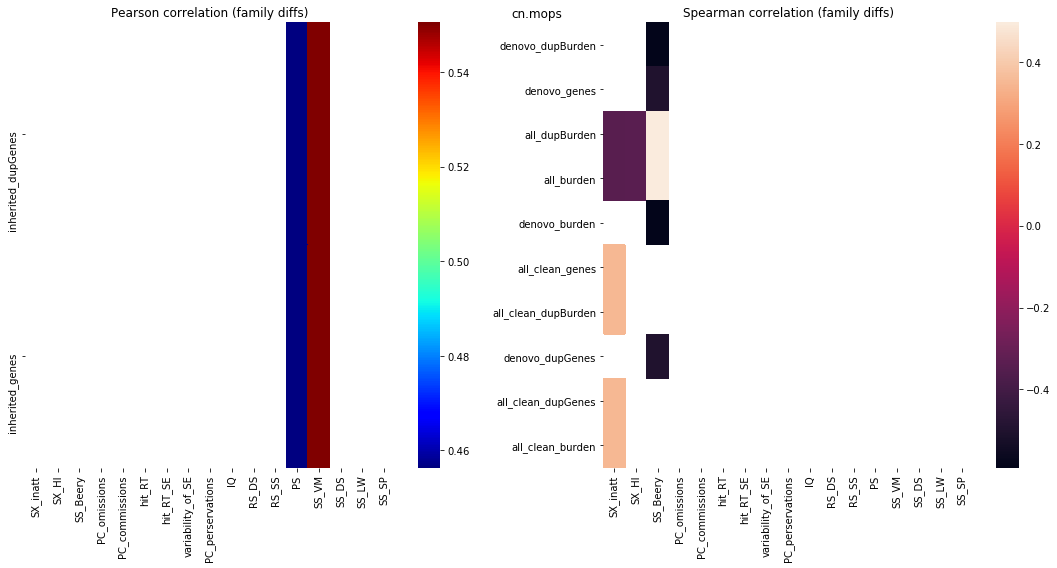

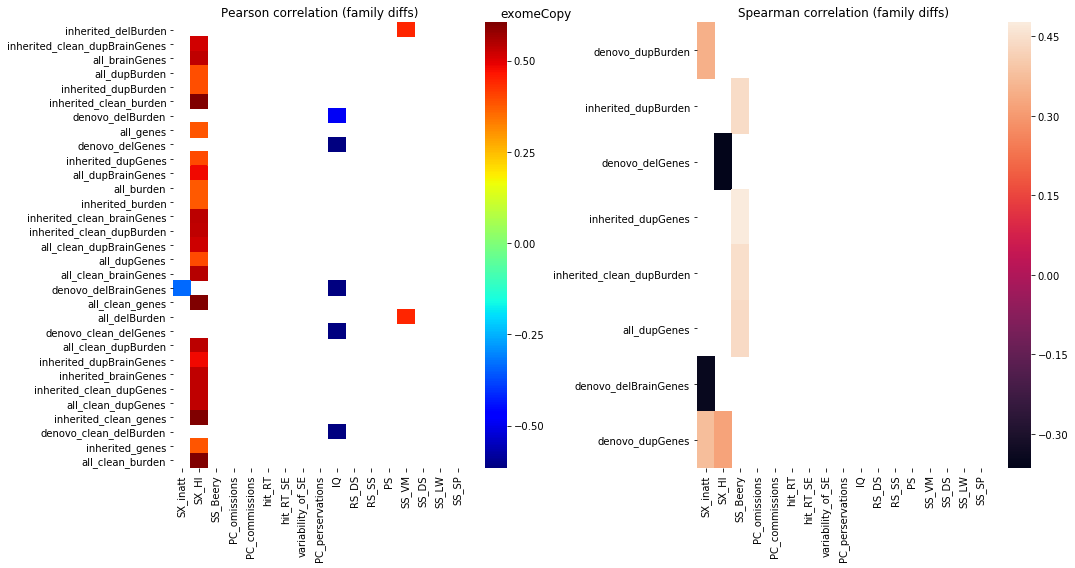

In [118]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for tool in ['conifer', 'cn.mops', 'exomeCopy']:
    data_dir = '/home/sudregp/data/cnv/%s_multikids/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation (family diffs)')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation (family diffs)')
    plt.suptitle('%s' % tool)
    plt.tight_layout()
    plt.show()

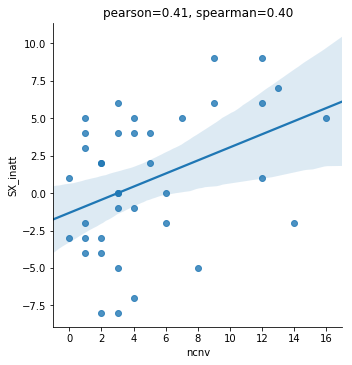

In [49]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/conifer_multikids/inherited_delBurden.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

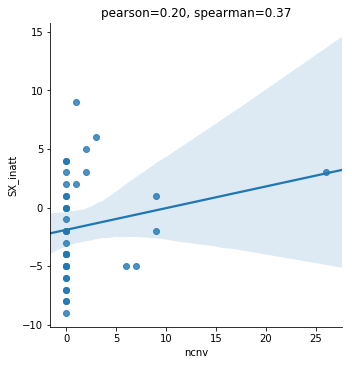

In [125]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/exomeCopy_multikids/denovo_dupGenes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

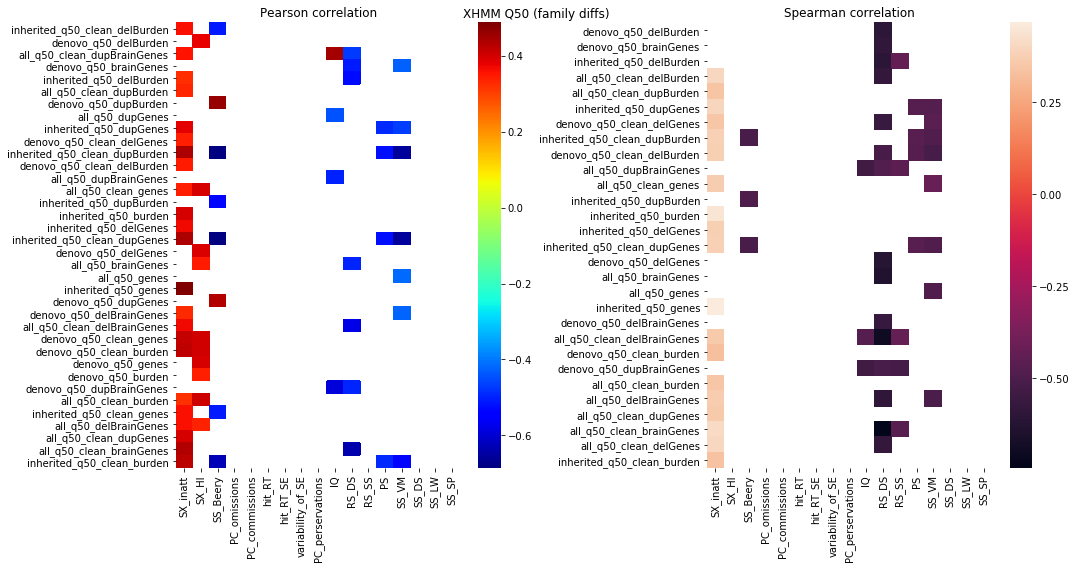

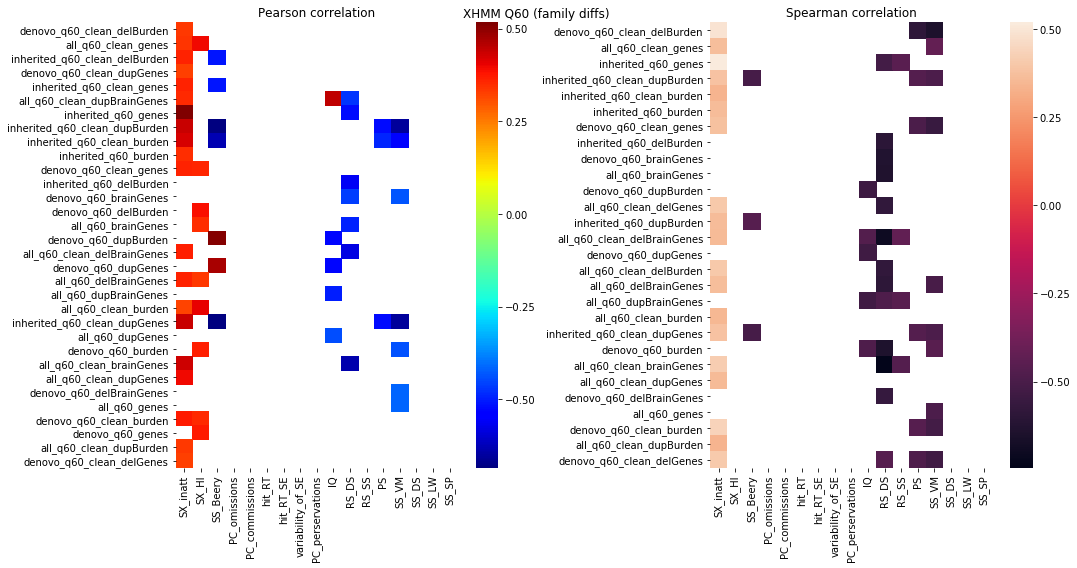

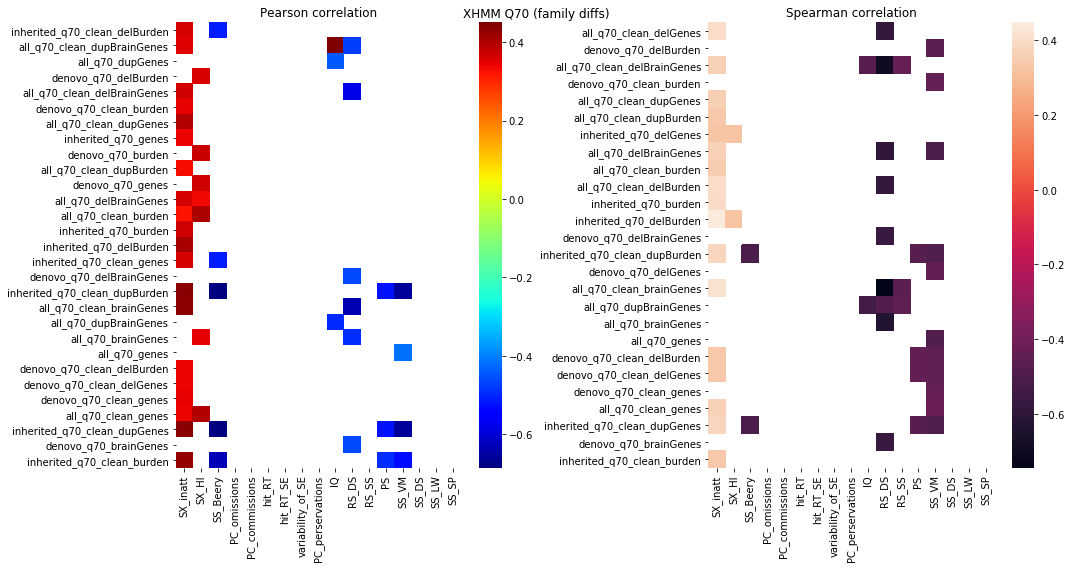

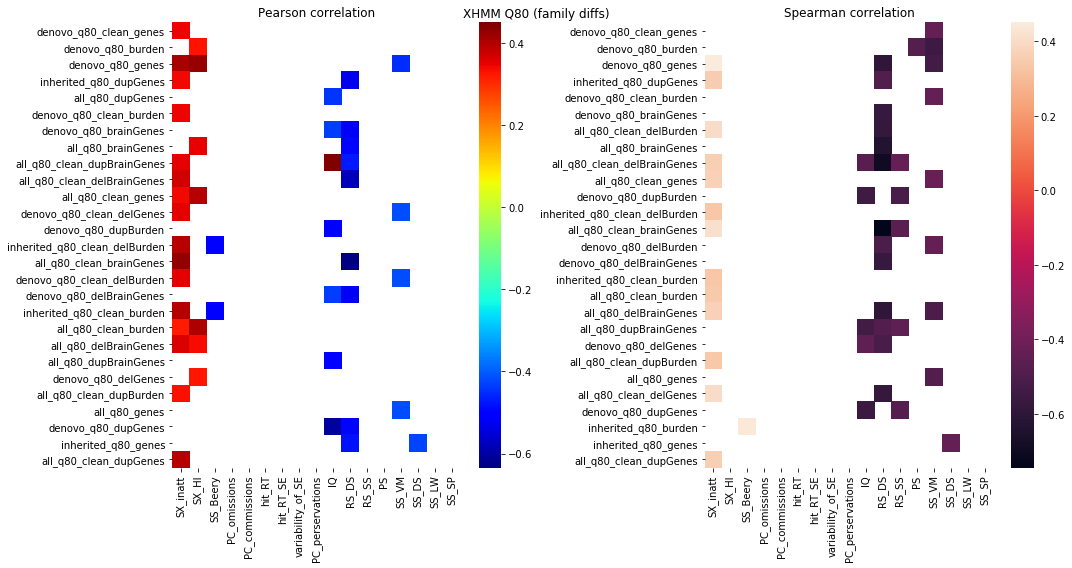

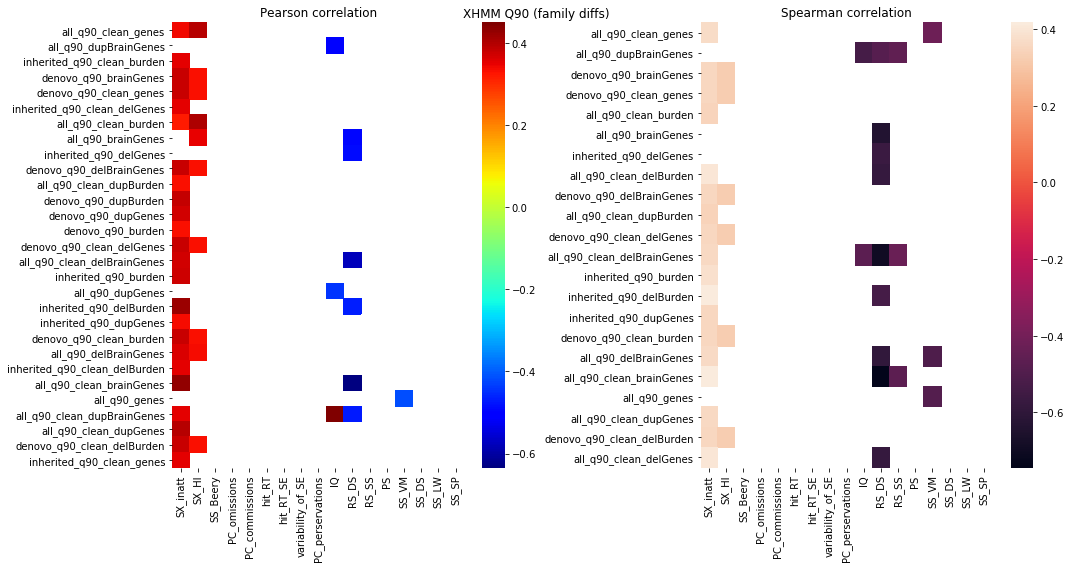

In [50]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

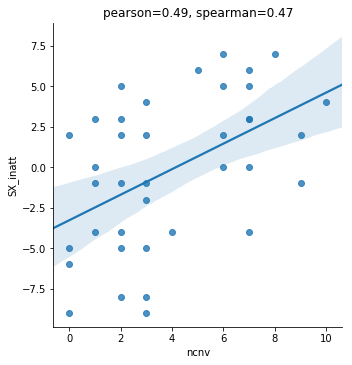

In [52]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/inherited_q50_genes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

Very clear here as well... the bigger the delta in CNVs (total), the bigger the delta in symptoms of inattention.

# Cleanup

Let's do some clean up of the results, showing only inherited and denovos, and not worry about the clean results. We could maybe make the case here that this is the discovery sample, and we'll evaluate the inherited variants in the bigger multiplex sample.

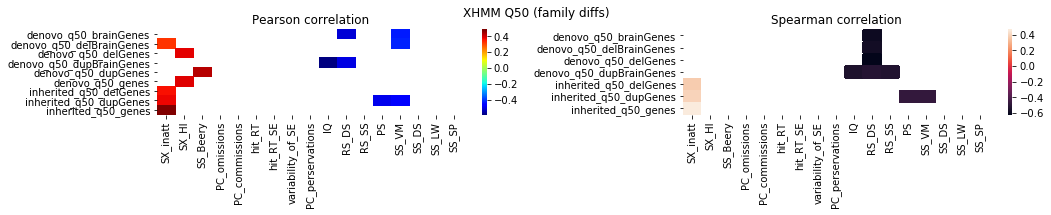

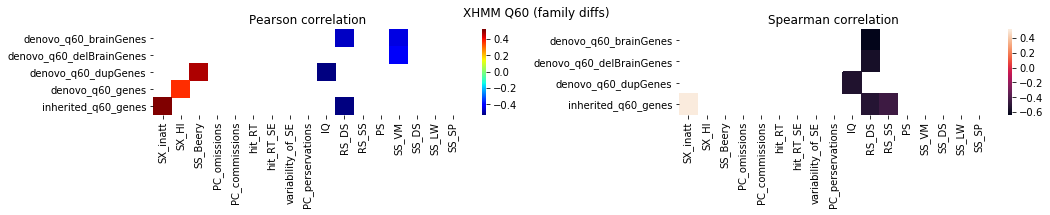

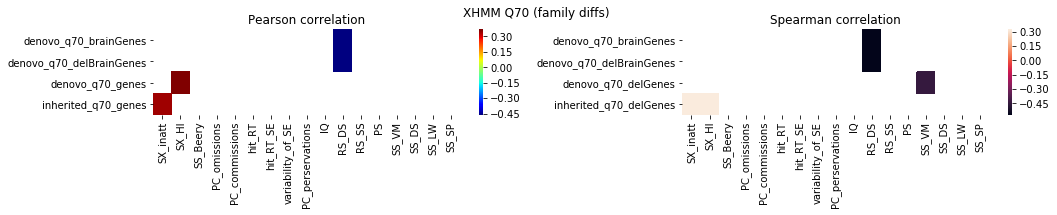

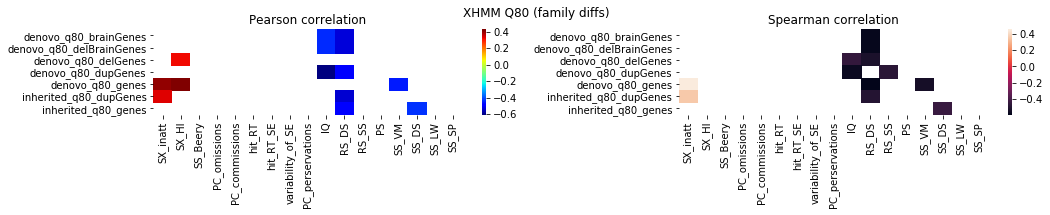

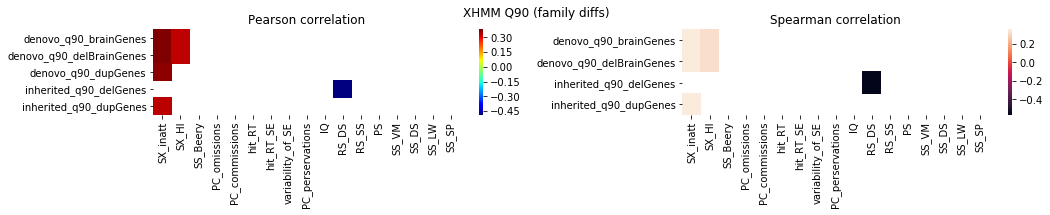

In [64]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('all') < 0 and 
                                   f.find('clean') < 0 and
                                   f.find('urden') < 0)]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

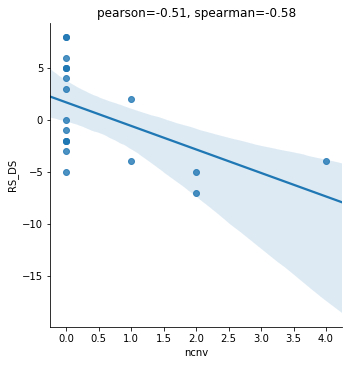

In [66]:
y='RS_DS'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/denovo_q50_brainGenes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

The issue with the brainGenes results is that they'll be heavily biased by 400178 results, which are all deletions anyways.

Let's switch tactics and just look at inherited results, and then just denovos.

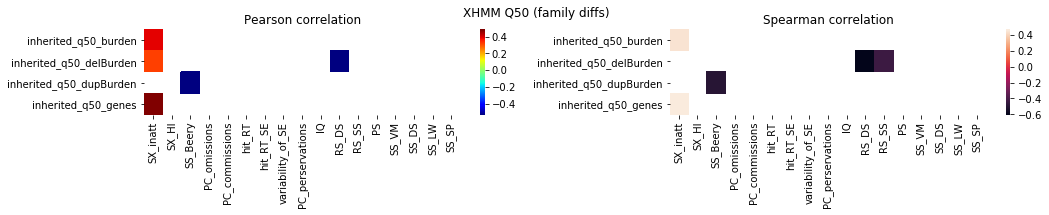

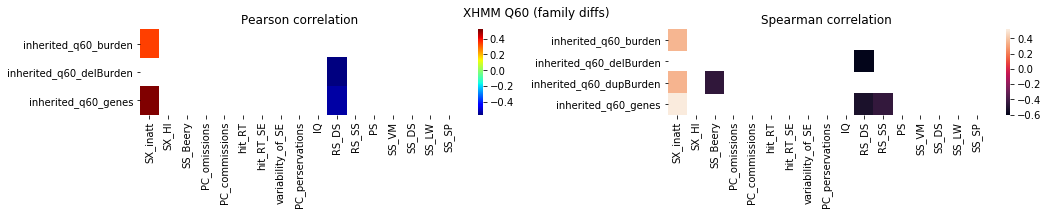

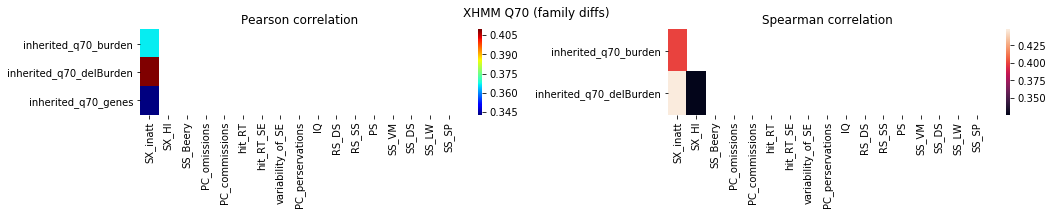

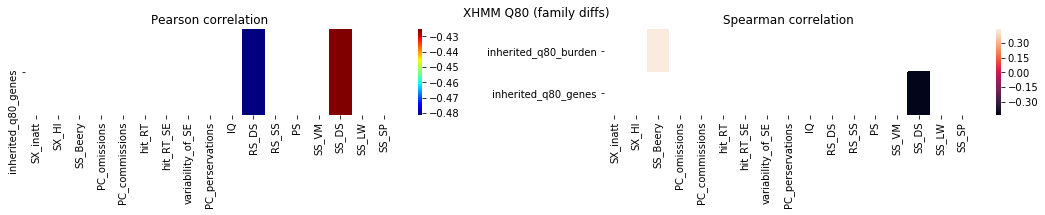

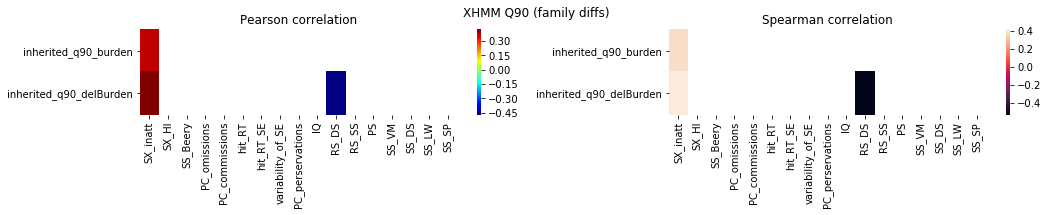

In [74]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('inherited') >= 0 and 
                                   f.find('clean') < 0 and
                                   (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

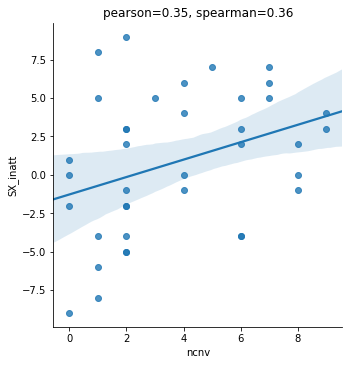

In [75]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/inherited_q60_burden.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

So, say we go with Q60, similar to what was used in the original paper. Then, we can use inherited_q60_burden.cnv.indiv to show that there is a link between SX_inatt difference and CNV difference, and that link holds for Q50 and Q70, and possibly other ones as well (maybe less strong). Then,w e can even split del and dups, and it's still significant (for one of them). Then, we should probably come up with some genetic pathways based on the regions affected by CNVs, and possibl confirm those findings in the multiplex sample. We could even add some brain variables here, if we have the data and want to get fancier. We could even add the Beery and/or RS_DS in the mix as well (or a PCA of DS and SS).

But looking at the scatterplot, it seems like having more cnvs doesn't necessarily leads to more symptoms. For example, we have 4 kids with more cnvs than their siblings, who have less innattention symptoms than the siblings. So, maybe we need a t-test to see if a variable is worth pursuing? Or maybe the CNV needs to be in specific regions of the DNA? Or of a certain length? ... many questions...

Then, say we focus on the denovos. Again, the trick here is to not get caught by 400178, which might make us do a more single-sample analysis. Or, remove that one and see if whatever we find without it still holds for it. Let's try this second approach:

In [78]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()
exclude_list += ['CLIA_400178', 'CLIA_400179', 'CLIA_400180']

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 83 samples, in 19 families


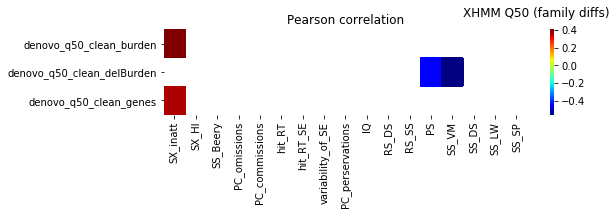

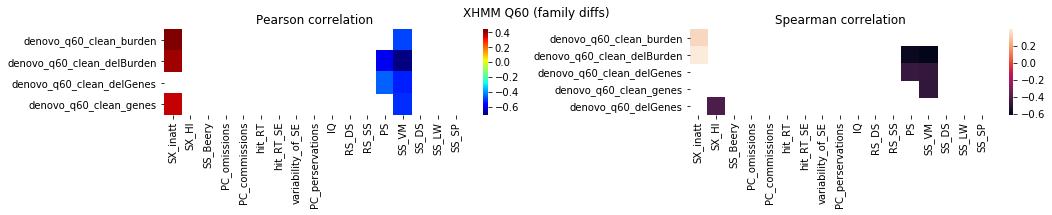

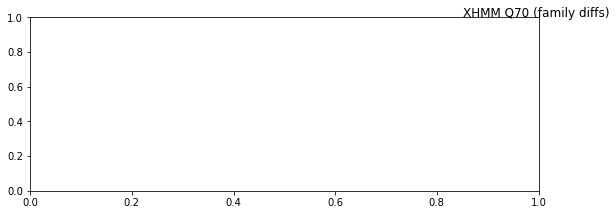

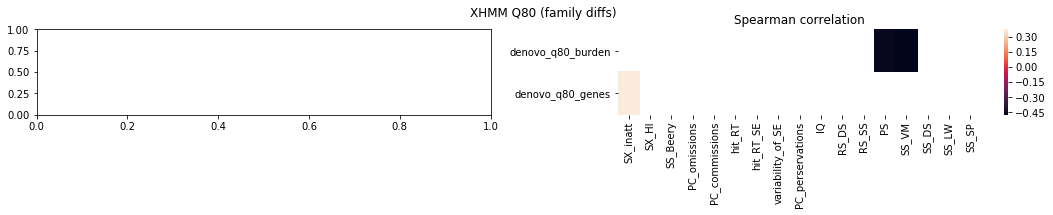

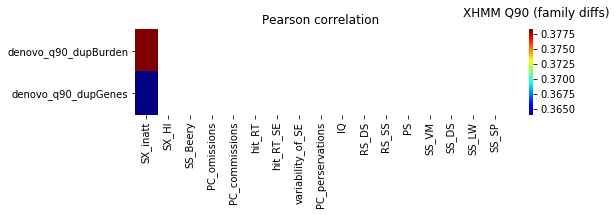

In [79]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('denovo') >= 0)]# and 
#                                    f.find('clean') < 0 and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

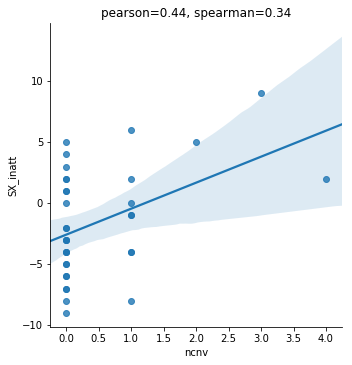

In [80]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/denovo_q60_clean_burden.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

So, in a way working only with the clean set for denovo is fine, because it gets rid of well-known variants. But excluding 400178 didn't help much either... I wonder if I should be spending this much time here if our final cleaning pipeline might change anyways. Maybe focus on writing the scripts to zoom in different samples, and the multiplex analysis?

If anything, we need a better way to run samples for which there are no cnv difference, because otherwise their sign is random. I think it's fair to not include them, and there is no way to determine a sign for their phenotypic difference.

# No zeros included

In [119]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [120]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = []
                            for y in (y_cols + [x]):
                                if np.float(row1[x]) > np.float(row2[x]):
                                    new_row.append(np.float(row1[y]) - 
                                                   np.float(row2[y]))
                                elif np.float(row2[x]) > np.float(row1[x]):
                                    new_row.append(np.float(row2[y]) - 
                                                   np.float(row1[y]))
                                else:
                                    new_row.append(np.nan)
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + [x]))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))


# returns X and Y for a correlation plot
def get_xy(fname, ycol, diff=False, x='ncnv'):
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    
    if diff:
        # the idea is to create a new data frame that only has the differences
        # among the phenotypes
    
        # loop through families
        rows = []
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            # get all combinations of kids
            if len(fam_kids) > 1:
                for kid1, kid2 in combinations(fam_kids, 2):
                    if kid1 in good_kids and kid2 in good_kids:
                        row1 = data[data['code'] == kid1]
                        row2 = data[data['code'] == kid2]
                        if np.float(row1[x]) > np.float(row2[x]):
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in [ycol, x]]
                        elif np.float(row2[x]) > np.float(row1[x]):
                            new_row = [np.float(row2[y]) - np.float(row1[y])
                                       for y in [ycol, x]]
                        else:
                            new_row = [np.nan, np.nan]
                    rows.append(new_row)
        data = pd.DataFrame(rows, columns=[ycol, x])

    tmp_df = data[[x, ycol]].dropna()
    return tmp_df

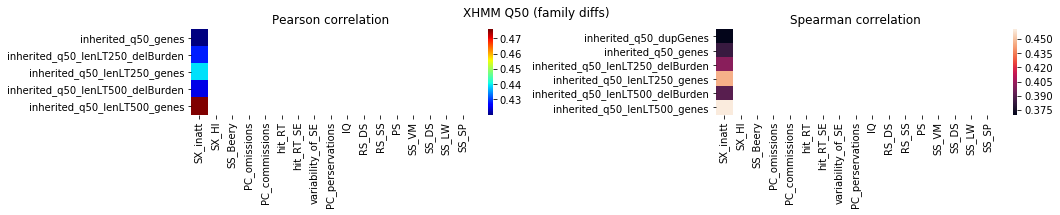

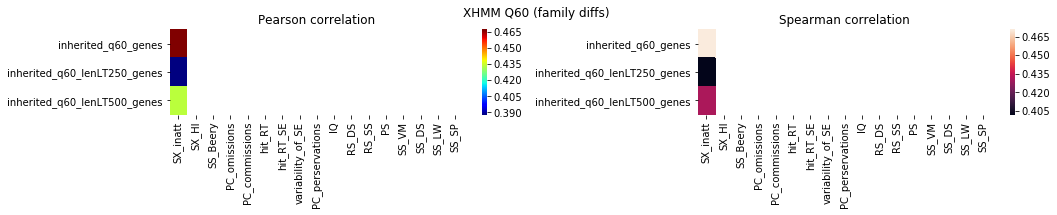

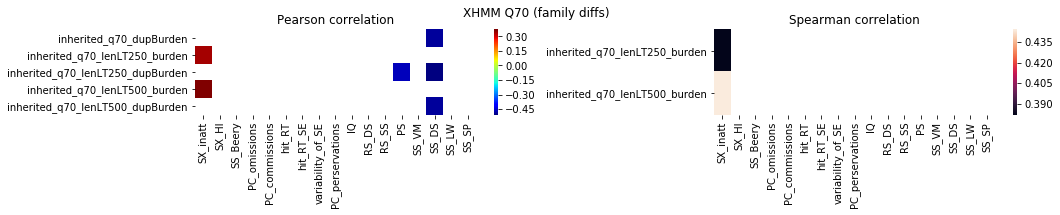

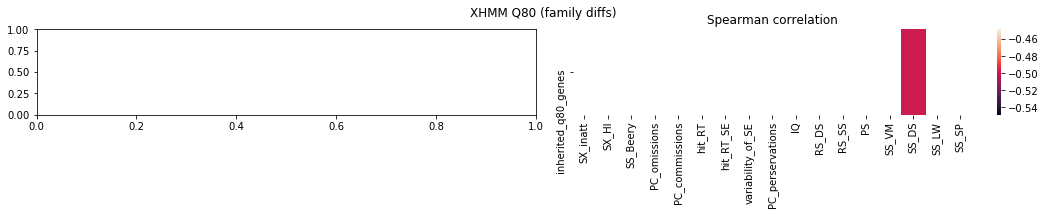

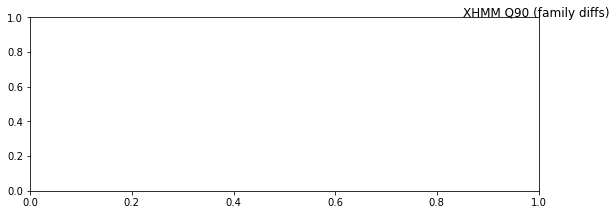

In [121]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('inherited') >= 0)]# and 
#                                    f.find('clean') < 0 and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

This seems to be a more fair assessment. As expected, higher QC thresholds have many 0 cnvs differences, and because of that don't produce a plot givent he number of points we're requiring as minimum. We could fudge it a little and require less points...

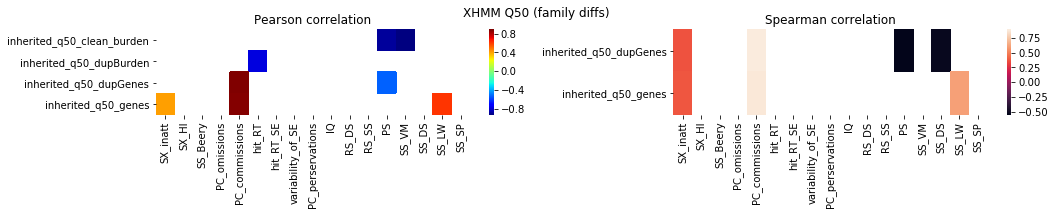

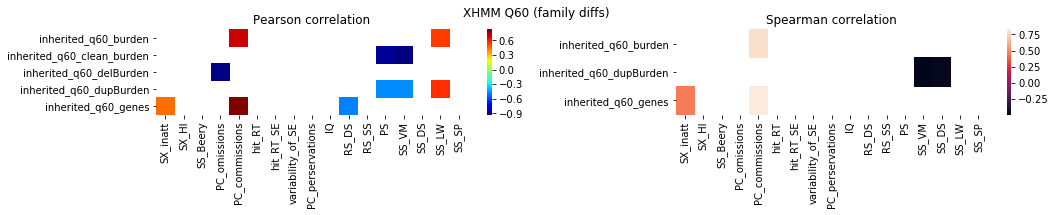

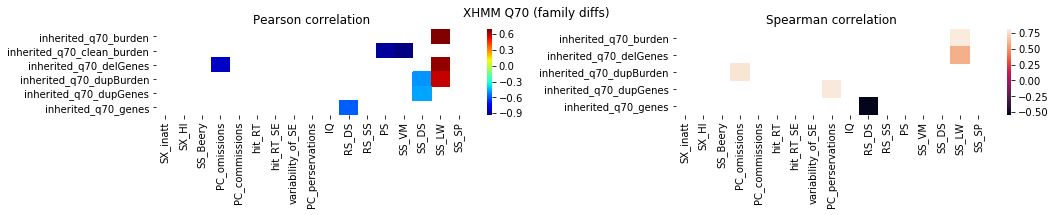

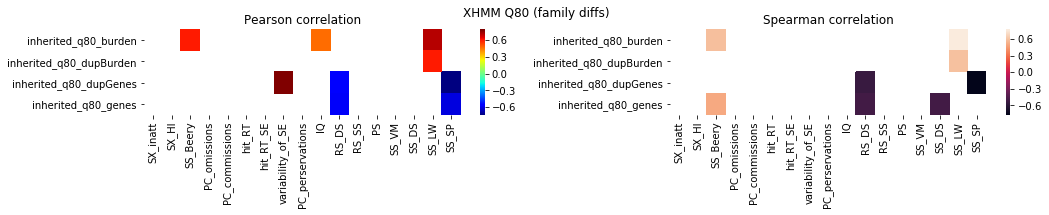

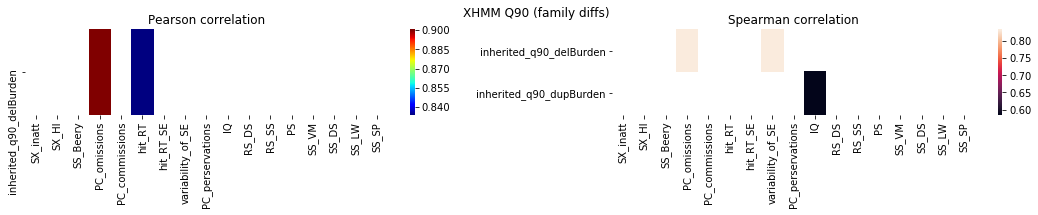

In [104]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('inherited') >= 0)]# and 
#                                    f.find('clean') < 0 and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=5, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

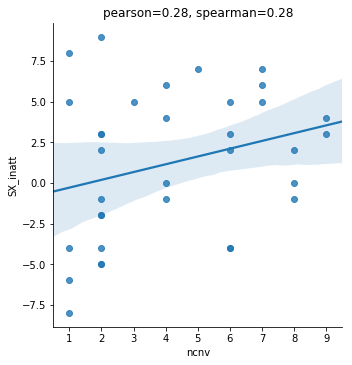

In [105]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/xhmm_multikids/inherited_q60_burden.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

As expected, that's a similar scatterplot as before, but without the 0 ncnv line. But unfortunately this doesn't mean much, as we still have many kid pairs with positive ncnv differences, but negative SX_inatt differences (i.e. the sibling with less symptoms has more cnvs). For kicks, let's check the other tools using this new code as well:

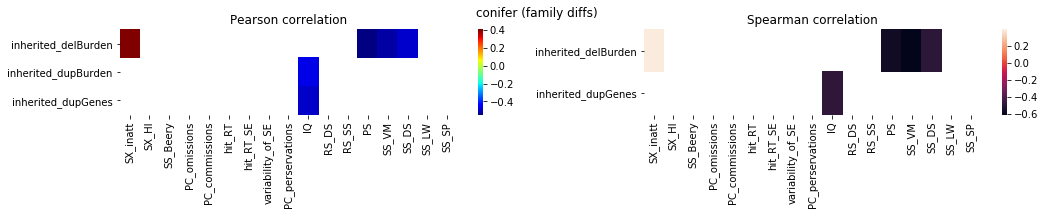

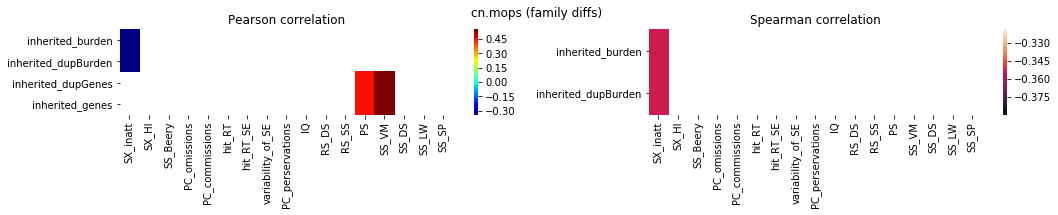

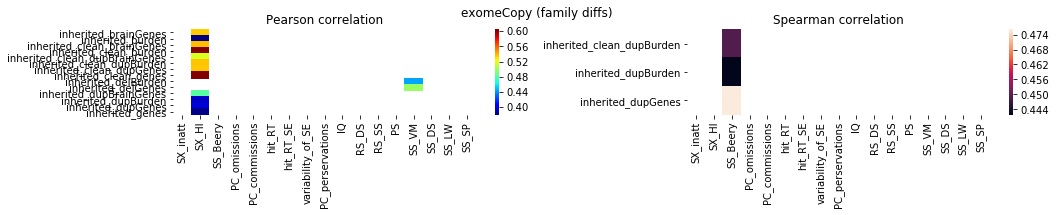

In [122]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for tool in ['conifer', 'cn.mops', 'exomeCopy']:
    data_dir = '/home/sudregp/data/cnv/%s_multikids/' % tool
    files = [f for f in glob.glob(data_dir + '/*cnv.indiv')]
    files2 = [f for f in files if (f.find('inherited') >= 0)]# and 
#                                    f.find('clean') < 0 and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('%s (family diffs)' % tool)
    plt.tight_layout()
    plt.show()

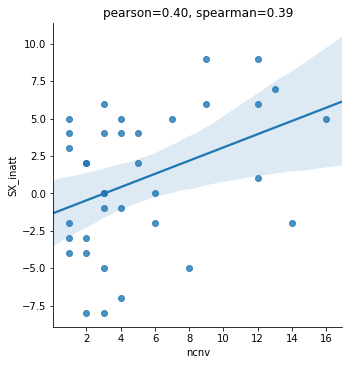

In [109]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/conifer_multikids/inherited_delBurden.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

Same idea, at least for conifer. cn.mops has the inverted sign... weird. Maybe we should implement the t-test idea?

# TODO
 * check results for multiplex (outlier samples, etc) and plot the non-diff plots using all multiplex+simplex samples, and then the diff plots using the same computations but only the simplex families.
 * try different similarity metrics (could use one of the many nonlinear methods in sklearn, but then would need to derive p-values through permutation!)
 * play with each tool parameters to see if we can get better results